In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("housing.csv")

### EDA

<Axes: ylabel='Density'>

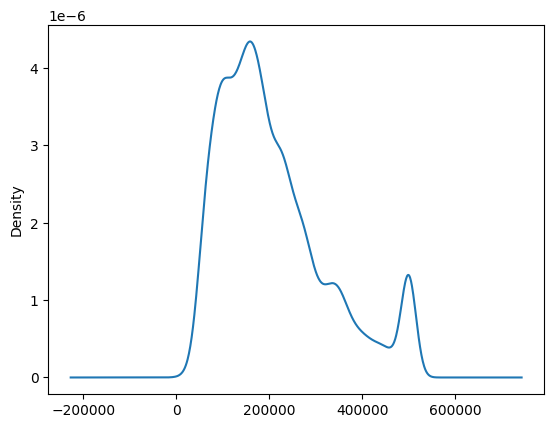

In [3]:
df["median_house_value"].plot(kind="density")

### Preparing the dataset

In [4]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
df = df[df["ocean_proximity"].isin(["<1H OCEAN", "INLAND"])]
df = df[['latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value']]

### Q1

In [6]:
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Q2

In [7]:
df["population"].median()

1195.0

### Prepare and split the dataset

In [8]:
df["median_house_value"] = np.log1p(df["median_house_value"])

In [9]:
def train_test_split(df, seed=42):
    train_size = int(len(df)*0.6)
    val_size = int(len(df)*0.2)
    test_size = len(df) - train_size - val_size

    idx = np.arange(len(df))
    rng = np.random.default_rng(seed=seed)
    rng.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:train_size].copy()
    df_val = df_shuffled.iloc[train_size:train_size+val_size].copy()
    df_test = df_shuffled.iloc[train_size+val_size:].copy()

    return df_train, df_val, df_test

In [10]:
df_train, df_val, df_test = train_test_split(df, seed=42)

### Q3

In [11]:
target = "median_house_value"

In [12]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [13]:
df_0 = df.copy()
df_0["total_bedrooms"] = df["total_bedrooms"].fillna(0)

In [14]:
def run_experiment(df_train, df_val, train_algo, **train_algo_params):
    X = df_train.drop(columns=target).to_numpy()
    y = df_train[target].to_numpy()
    w_0, w = train_algo(X,y, **train_algo_params)

    pred = predict(df_val.drop(columns=target).to_numpy(), w_0, w)
    return rmse(df_val[target].to_numpy(), pred)

def predict(X, w_0, w):
    return X.dot(w) + w_0

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [15]:
score_0 = run_experiment(df_train.fillna(0), df_val.fillna(0), train_linear_regression)
score_0.round(2)

0.33

In [16]:
total_bedrooms_mean = df_train["total_bedrooms"].mean()
train_mean = df_train.fillna(total_bedrooms_mean)
val_mean = df_val.fillna(total_bedrooms_mean)
score_mean = run_experiment(train_mean, val_mean, train_linear_regression)
score_mean.round(2)

0.33

### Q4

In [17]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [18]:
scores = {}
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    score = run_experiment(df_train.fillna(0), df_val.fillna(0), train_linear_regression_reg, r=r)
    scores[r] = score.round(2)
scores

{0: 0.33,
 1e-06: 0.33,
 0.0001: 0.33,
 0.001: 0.33,
 0.01: 0.33,
 0.1: 0.33,
 1: 0.33,
 5: 0.33,
 10: 0.33}

In [19]:
min(scores, key=scores.get)

0

### Q5

In [20]:
scores = {}
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, df_val, df_test = train_test_split(df.fillna(0), seed=seed)
    score = run_experiment(df_train, df_val, train_linear_regression)
    scores[seed] = score

In [21]:
scores

{0: 0.3389126222393566,
 1: 0.3460797334706926,
 2: 0.3507314381165553,
 3: 0.3387693686530782,
 4: 0.3389102666789322,
 5: 0.34737890541626054,
 6: 0.3364739453884381,
 7: 0.3340916764131837,
 8: 0.33580590296267404,
 9: 0.33864161952470606}

In [22]:
np.array(list(scores.values())).std().round(3)

0.005

### Q6

In [23]:
df_train, df_val, df_test = train_test_split(df.fillna(0), seed=9)



In [24]:
df_train.shape, df_val.shape

((9412, 9), (3137, 9))

In [25]:
run_experiment(pd.concat([df_train, df_val]), df_test, train_linear_regression_reg, r=0.001)

0.33765680450284996